Dataset downloaded!

Loading images...
Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Starting Training (approx 2-3 mins)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.3994 - loss: 1.7007 - val_accuracy: 0.5387 - val_loss: 0.9411
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.5476 - loss: 0.9462 - val_accuracy: 0.5387 - val_loss: 0.9700
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.6303 - loss: 0.8313 - val_accuracy: 0.6373 - val_loss: 0.8389
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.7295 - loss: 0.6625 - val_accuracy: 0.6333 - val_loss: 0.8261
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.8202 - loss: 0.4727 - val_accuracy: 0.6227 - val_loss: 0.9260
Training Complete!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


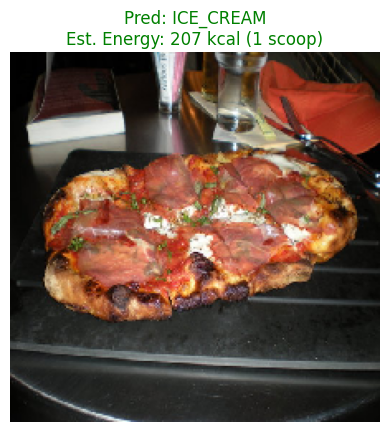

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---------------------------------------------------------
# STEP 1: LOAD DATA (Subset for Speed)
# ---------------------------------------------------------
# We download a 10-class subset of Food-101 used for education
print("Downloading dataset...")
!wget -q https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

print("Dataset downloaded!")

# We will focus on 3 specific classes to make training fast & accurate
# Classes: Pizza, Hamburger, Ice Cream
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

# ---------------------------------------------------------
# STEP 2: PREPROCESSING
# ---------------------------------------------------------
# Normalize images and filter only the classes we want
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("\nLoading images...")
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['pizza', 'hamburger', 'ice_cream'] # We explicitly pick these 3
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['pizza', 'hamburger', 'ice_cream']
)

# ---------------------------------------------------------
# STEP 3: CALORIE MAP
# ---------------------------------------------------------
# Since the model predicts the *name*, we need a dictionary to get calories.
# Values are approximate averages per serving.
calories_dict = {
    'pizza': '266 kcal (1 slice)',
    'hamburger': '295 kcal (1 burger)',
    'ice_cream': '207 kcal (1 scoop)'
}

# ---------------------------------------------------------
# STEP 4: BUILD MODEL (CNN)
# ---------------------------------------------------------
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') # 3 output neurons for our 3 classes
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# ---------------------------------------------------------
# STEP 5: TRAIN
# ---------------------------------------------------------
print("\nStarting Training (approx 2-3 mins)...")
history = model.fit(train_data, epochs=5, validation_data=test_data)

print("Training Complete!")

# ---------------------------------------------------------
# STEP 6: TEST & ESTIMATE CALORIES
# ---------------------------------------------------------
def predict_food(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)

    # Get class label from the generator
    labels = list(train_data.class_indices.keys())
    predicted_label = labels[class_index]

    # Get calories
    cal_info = calories_dict[predicted_label]

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {predicted_label.upper()}\nEst. Energy: {cal_info}", color='green')
    plt.show()

# Run a prediction on a sample test image
import random
# Pick a random image from the test set folder of 'pizza'
sample_dir = "10_food_classes_all_data/test/pizza/"
sample_file = random.choice(os.listdir(sample_dir))
predict_food(sample_dir + sample_file)